In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import statsmodels.stats.multitest as smt

In [2]:
def sample_gen(n ) :
    arr = []
    for j in range(n) :
        arr.append([np.random.normal(0,1.0) , np.random.normal(0,1.0)])
    return np.array(arr).T
def get_corr_sample(sample , rho) :
    alpha = (np.sqrt(1+rho) + np.sqrt(1-rho))/2
    beta = (np.sqrt(1+rho) - np.sqrt(1-rho))/2
    A_rho = [[alpha , beta],[beta , alpha]]
    return A_rho@sample
def T(X) :
    return np.sum(X[0]*X[1])/len(X[0])
def T_2(X) :
    return np.sum((X[0]-X[1])**2)/len(X[0])/2
def get_W(n , criterion , num_samples ,rho_arr) :
    W = []
    for rho in rho_arr :
        count_reject = []
        for _ in range(num_samples) :
            sample = sample_gen(n)
            sample = get_corr_sample(sample , rho)
            count_reject.append(criterion(sample))
        W.append( sum(count_reject) / num_samples)
    return W
def crit_1(sample)  :
    return np.abs(T(sample)) > 20/n
def crit_2(sample) :
    return np.abs(T_2(sample)-1) > 1.96*np.sqrt(2)/np.sqrt(n)
def crit_1_by_alpha(sample , alpha ) :
    return np.abs(T(sample)) > 1/(len(sample) * alpha)

In [3]:
def get_p_values(num_samples ,rho , n=100 ) :
    p_values = []
    sigma = np.sqrt(1/n)
    for _ in range(num_samples) :
        sample = sample_gen(n)
        sample = get_corr_sample(sample , rho)
        stat = np.abs(T(sample))
        left = norm.cdf( -stat , loc=0, scale=sigma )
        p_values.append(2*left)
    return np.array(p_values)    

#### FWER = P(V>0) . V - это число сэмплов , когда мы отвергли гипотезу {$\rho = 0$} при ее верности. Хотим оценить эту вероятность , значит нужен еще один цикл сэмплирования.

In [4]:
n = 100
rho_1  = 0
rho_2 = 0.2
num_samples = 500


## Посэмплируем и проверим как работают поправки

#### Без поправки Бонферони - FWER :

In [48]:
N_sampling = 100
counter = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(num_samples,rho_1,n)
    p_values_2 = get_p_values(num_samples,rho_2,n)
    counter += np.sum(p_values_1 < 0.05) > 0 

print(counter /N_sampling)

1.0


#### FWER С поправкой  Бонферони: (как видим соотвестсвует теореме о том что поправка позволяет контролировать FWER на уровне $\alpha$)

In [107]:
N_sampling = 100
counter = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(num_samples,rho_1,n)
    new_p_values_1 = p_values_1*1000
    
    counter += np.sum(new_p_values_1 < 0.05) > 0

print(counter /N_sampling) 

0.02


#### FDR = $ E( \frac{\textbf{Число отвергнутых верных}}{отвергнутых} )$

#### FDR без поправки :

In [55]:
N_sampling = 100
value = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(num_samples,rho_1,n)
    p_values_2 = get_p_values(num_samples,rho_2,n)
    
    cnt_1 = np.sum( p_values_1 < 0.05 )
    cnt_2 = cnt_1 + np.sum( p_values_2 < 0.05)
    if cnt_2 != 0 :
        value += cnt_1/cnt_2

print( value/N_sampling) 

0.09050189686203985


#### Теперь реализуем поправку Бенджамина-Хохберга :
Как видим она контролируется примерно : FDR < $\frac{m_0}{m}\alpha$  (Примерно , так как у нас очень маленький сэмплинг , а большой очень долго запускать), А именно FDR $<\frac{\alpha}{2}$
По крайней мере она контролируется на уровне $\alpha$

#### FDR с поправкой

In [72]:
N_sampling = 100
value = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(num_samples,rho_1,n)
    p_values_2 = get_p_values(num_samples,rho_2,n)
    p_values__all = np.concatenate([p_values_1,p_values_2])
    sorted_index = np.argsort(p_values__all)
    p_values__all = p_values__all[sorted_index]
    corrected_p_values = smt.multipletests( p_values__all, method='fdr_bh')[1]

    inverse_index = np.argsort(sorted_index)

    new_p_values_all = corrected_p_values[inverse_index]

    new_p_values_1 = new_p_values_all[:500]
    new_p_values_2 = new_p_values_all[500:]
    cnt_1 = np.sum( new_p_values_1 < 0.05 )
    cnt_2 = cnt_1 + np.sum( new_p_values_2 < 0.05)
    if cnt_2 != 0 :
        value += cnt_1/cnt_2
print( value/N_sampling) 

0.0293624896143638


In [11]:
N_sampling = 1
value = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(num_samples,rho_1,n)
    p_values_2 = get_p_values(num_samples,rho_2,n)
    p_values__all = np.concatenate([p_values_1,p_values_2])
    sorted_index = np.argsort(p_values__all)
    p_values__all = p_values__all[sorted_index]
    corrected_p_values = smt.multipletests( p_values__all, method='fdr_bh')[1]

    inverse_index = np.argsort(sorted_index)

    new_p_values_all = corrected_p_values[inverse_index]

    new_p_values_1 = new_p_values_all[:500]
    new_p_values_2 = new_p_values_all[500:]
    cnt_1 = np.sum( new_p_values_1 < 0.05 )
    cnt_2 = cnt_1 + np.sum( new_p_values_2 < 0.05)
    if cnt_2 != 0 :
        value += cnt_1/cnt_2
print( value/N_sampling) 

0.01834862385321101


####  Посмотрим , как выглядит положительная регрессионная зависимость

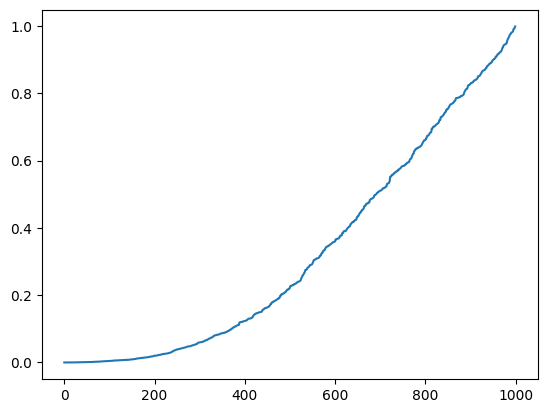

In [12]:
plt.plot(p_values__all)
plt.show()

## Теперь Генерим 1000 с.в. с одинаковым $\rho = 0$

#### FWER без поправки 

In [82]:
N_sampling = 100
counter = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(1000,rho_1,n)
    counter += np.sum(p_values_1 < 0.05) > 0 

print(counter /N_sampling)

1.0


#### FWER С поправкой Бонферрони : (FWER <=$\alpha$)

In [108]:
N_sampling = 100
counter = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(2*num_samples,rho_1,n)
    new_p_values_1 = p_values_1*1000
    
    counter += np.sum(new_p_values_1 < 0.05) > 0

print(counter /N_sampling) 

0.05


#### FDR  без поправки : (В случае когда неверных гипотез = 0 ,то  FDR = FWER )

In [109]:
N_sampling = 100
value = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(2*num_samples,rho_1,n)
    
    cnt = np.sum( p_values_1 < 0.05)
    if cnt != 0 :   
        value +=1
    
print( value/N_sampling) 

1.0


####  FDR С поправкой Бенджаммини-Хохберга ( = FWER , т.к. E(1_{R>0}) = P(R>0) =P(V>0))

In [111]:
N_sampling = 100
value = 0
for j in range(N_sampling) :
    p_values_1 = get_p_values(2*num_samples,rho_1,n)
    sorted_index = np.argsort(p_values_1)
    p_values_1 = p_values_1[sorted_index]
    corrected_p_values = smt.multipletests( p_values_1, method='fdr_bh')[1]

    inverse_index = np.argsort(sorted_index)

    new_p_values_1 = corrected_p_values[inverse_index]

    value += np.sum( new_p_values_1 < 0.05 ) > 0
print( value/N_sampling) 

0.06


#### Положительная регрессионная зависимость для этого случая 

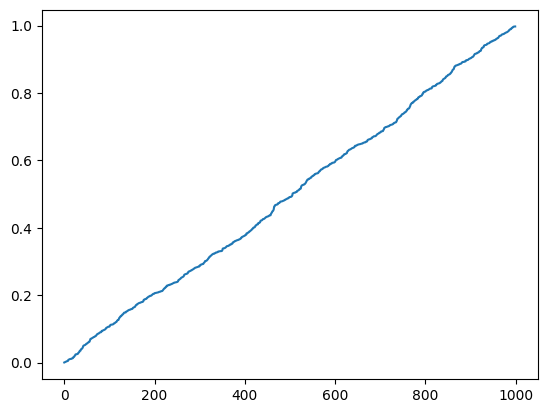

In [10]:
plt.plot(p_values_1)
plt.show()